** Importing things **

Basically ensuring we have access to all the libraries going forward

In [1]:
import csv
import cv2
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam
from keras.regularizers import l2, activity_l2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pickle
import random
from sklearn import preprocessing
from sklearn.utils import shuffle
import tensorflow as tf

tf.python.control_flow_ops = tf


Using TensorFlow backend.


** Image transformation functions **

In [2]:
# Reflection transformation
def reflect_image(image):
    return cv2.flip(image, 1)

class reflection(object):
    def __init__(self, images):
        self.images = images
        self.current = 0
        self.size = len(images)
    def __iter__(self):
        return self
    def __next__(self):
        return self._next()
    def _next(self):
        if self.current < self.size:
            image, self.current = self.images[self.current], self.current + 1
            return reflect_image(image)
        else:
            raise StopIteration()

In [3]:
# Image resize
def resize_image(image_in, dimensions=(64,16)):
    """
    Resizes the input image to the specified dimensions
    """
    top = 60
    bottom = 140
    left = 0
    right = len(image_in[0]) - 1
    return cv2.resize(image_in[top:bottom, left:right], dimensions, interpolation = cv2.INTER_AREA)

** Data loading utilities **

Functions to make it easly to load the data from disk

In [4]:
def read_image_data(path):
    """
    Loads an image file, resizes it, returns it as a numpy array
    """
    return np.array(resize_image(mpimg.imread(path)))

def load_data(data_folder="./data/"):
    """
    Loads the training data from the specified folder
    """
    pickle_file = data_folder + "data.pickle"
    if os.path.exists(pickle_file):
        print('Loading data from pickle file...')
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
            images = pickle_data["images"]
            steering = pickle_data["steering"]
            del pickle_data
        return images, steering
    images = []
    steering = []
    angle_adjustment = 0.15
    center_image_retention_rate = 0.1
    with open(data_folder + "driving_log.csv", 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            steering_angle = float(row["steering"])
            if steering_angle == 0:
                # decide if this one is going to be retained
                if random.random() > center_image_retention_rate:
                    continue
            #center,left,right,steering,throttle,brake,speed
            images.append(read_image_data(data_folder + row["center"].strip()))
            steering.append(steering_angle)
            images.append(read_image_data(data_folder + row["left"].strip()))
            left_steering = steering_angle + angle_adjustment
            steering.append(1. if left_steering > 1 else -1. if left_steering < -1 else left_steering)
            images.append(read_image_data(data_folder + row["right"].strip()))
            right_steering = steering_angle - angle_adjustment
            steering.append(1. if right_steering > 1 else -1. if right_steering < -1 else right_steering)
    images = np.array(images)
    steering = np.array(steering)
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    "images": images,
                    "steering": steering,
                },
                pfile, pickle.DEFAULT_PROTOCOL)
    except Exception as e:
        print("Unable to save data to", pickle_file, ":", e)
        raise
    return images, steering


** Data preprocessing and normalization**

Utilities to prepare the data before it's shoveled into the model

Saving data to pickle file...


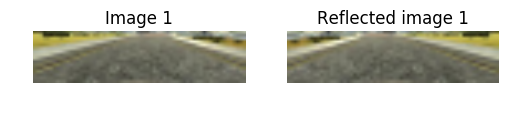

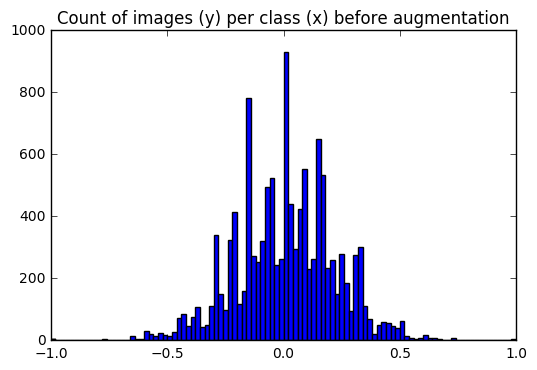

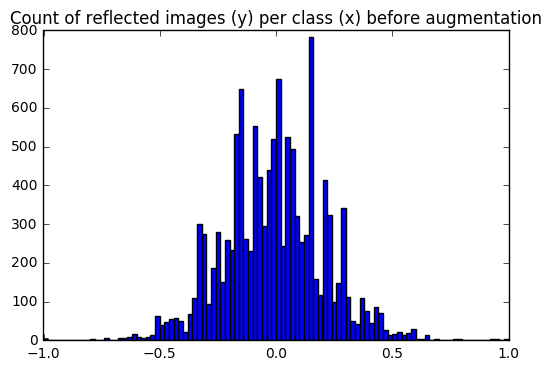

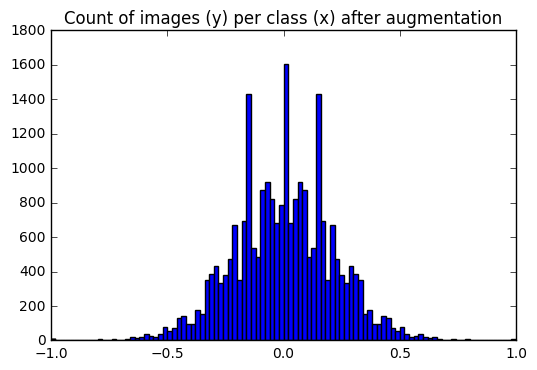

0.0
-0.0


In [5]:
def balance(X_input, y_input):
    """
    It will take the data input and attempt to balance the data set so that
    the training isn't squewed towards any given class
    """
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(X_train[0])
    axes[0].set_title("Image 1")
    axes[0].axis("off")
    axes[1].imshow(reflect_image(X_train[0]))
    axes[1].set_title("Reflected image 1")
    axes[1].axis("off")
    plt.show()
    plt.hist(y_input, bins=100)
    plt.title("Count of images (y) per class (x) before augmentation")
    plt.show()
    tupni_X = [reflect_image(i) for i in X_input]
    tupni_y = [-i for i in y_input]
    plt.show()
    plt.hist(tupni_y, bins=100)
    plt.title("Count of reflected images (y) per class (x) before augmentation")
    plt.show()
    X_output = np.concatenate((X_input, tupni_X), axis=0)
    y_output = np.concatenate((y_input, tupni_y), axis=0)
    plt.hist(y_output, bins=100)
    plt.title("Count of images (y) per class (x) after augmentation")
    plt.show()
    print(y_input[0])
    print(tupni_y[0])
    return X_output, y_output

source = "./data/"
data_pickle = source + "data.pickle"
if os.path.exists(data_pickle):
    os.remove(data_pickle)

X_train, y_train = load_data(source)
X_train, y_train = balance(X_train, y_train)


In [6]:
def normalize_minmax(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [-0.5, 0.5]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = -0.5
    b = 0.5
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

** Model definition **

Function that creates the model

In [7]:
def nvidia_make_model(n_classes, input_shape, dropout_rate=0.5, learning_rate=0.00005):
    """
    Creates the keras model used for our network, based on the NVidia paper titled
    End-to-End Learning for Self-Driving Cars
    http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
    """
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, border_mode='valid',  subsample=(2, 2), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    model.add(Convolution2D(36, 5, 5, border_mode='same',  subsample=(2, 2)))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    model.add(Convolution2D(48, 5, 5, border_mode='same',  subsample=(2, 2)))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    model.add(Convolution2D(64, 3, 3, border_mode='same'))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    model.add(Convolution2D(64, 3, 3, border_mode='same'))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(1164))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes))
    print(model.summary())

    #model.compile(optimizer='adam', loss='mse')
    adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss='mse')

    return model
    

def make_model(n_classes, input_shape, dropout_rate=0.5, regularizer_rate=0.0001):
    """
    Creates the keras model used for our network
    """
    model = Sequential()
    # Add a convolution with 32 filters, 3x3 kernel, and valid padding
    model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=input_shape))
    # Add a ReLU activation layer
    model.add(Activation('relu'))
    # Add a max pooling of 2x2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Add a dropout
    model.add(Dropout(dropout_rate))

    # Add a convolution with 64 filters, 2x2 kernel, and valid padding
    model.add(Convolution2D(64, 2, 2, border_mode='valid'))
    # Add a ReLU activation layer
    model.add(Activation('relu'))
    # Add a max pooling of 2x2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Add a dropout
    model.add(Dropout(dropout_rate))

    # Add a flatten layer
    model.add(Flatten())
    # Add a fully connected layer
    #model.add(Dense(128, W_regularizer=l2(regularizer_rate), activity_regularizer=activity_l2(regularizer_rate)))
    model.add(Dense(128))
    # Add a ReLU activation layer
    model.add(Activation('relu'))
    # Add a dropout
    model.add(Dropout(dropout_rate))
    # Add a fully connected layer
    #model.add(Dense(n_classes, W_regularizer=l2(regularizer_rate), activity_regularizer=activity_l2(regularizer_rate)))
    model.add(Dense(n_classes))
    print(model.summary())

    model.compile(optimizer='adam', loss='mse')
    return model

** Training **

Instantiate a model and train it with the data in disk

In [8]:
X_train, y_train = load_data("./data/")

print("Image shape:",X_train[0].shape)

# instantiate the model
model = nvidia_make_model(1, X_train[0].shape)

Loading data from pickle file...
Image shape: (16, 64, 3)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 6, 30, 24)     1824        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 6, 30, 24)     0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 6, 30, 24)     0           activation_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 3, 15, 36)     21636       dropout_1[0][0]                  
_________________________________

Training data from ./data/
Loading data from pickle file...


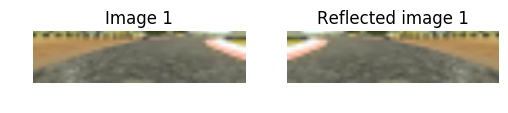

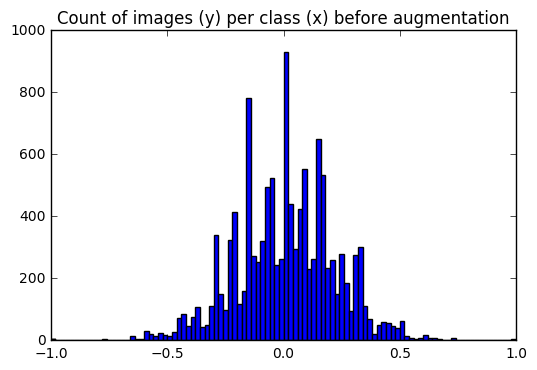

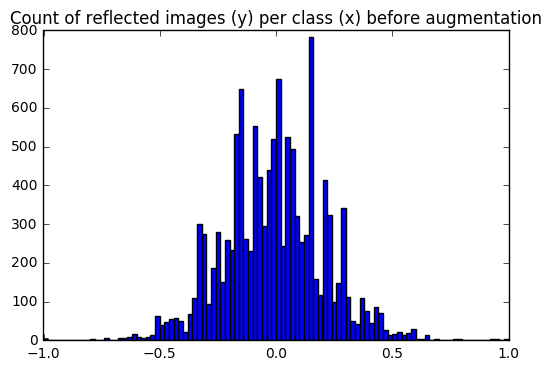

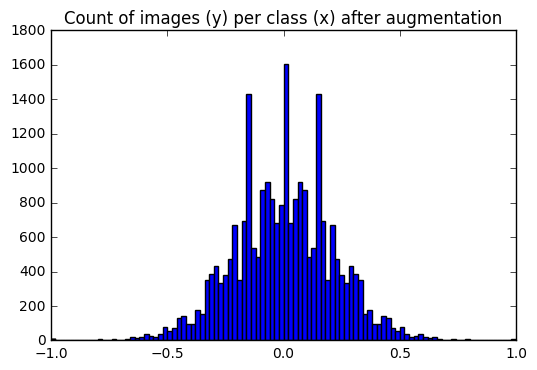

0.3583844
-0.3583844
Train on 19612 samples, validate on 4904 samples
Epoch 1/1000
19612/19612 [==============================] - 3s - loss: 0.0484 - val_loss: 0.0461
Epoch 2/1000
19612/19612 [==============================] - 1s - loss: 0.0469 - val_loss: 0.0456
Epoch 3/1000
19612/19612 [==============================] - 1s - loss: 0.0452 - val_loss: 0.0435
Epoch 4/1000
19612/19612 [==============================] - 1s - loss: 0.0423 - val_loss: 0.0402
Epoch 5/1000
19612/19612 [==============================] - 1s - loss: 0.0386 - val_loss: 0.0373
Epoch 6/1000
19612/19612 [==============================] - 1s - loss: 0.0350 - val_loss: 0.0364
Epoch 7/1000
19612/19612 [==============================] - 1s - loss: 0.0329 - val_loss: 0.0372
Epoch 8/1000
19612/19612 [==============================] - 1s - loss: 0.0316 - val_loss: 0.0364
Epoch 9/1000
19612/19612 [==============================] - 1s - loss: 0.0309 - val_loss: 0.0363
Epoch 10/1000
19612/19612 [==============================

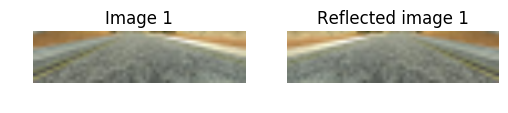

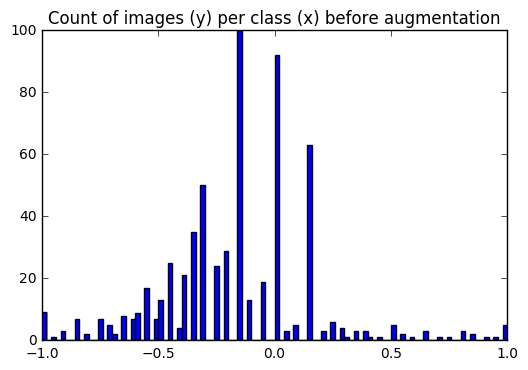

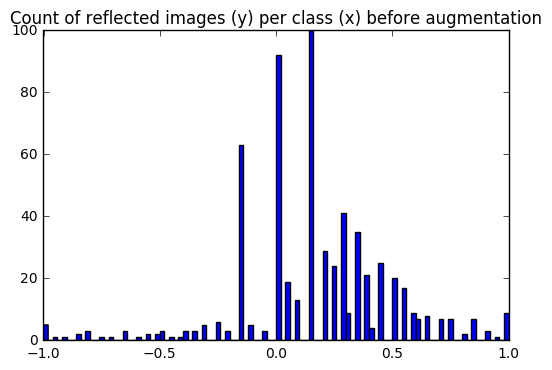

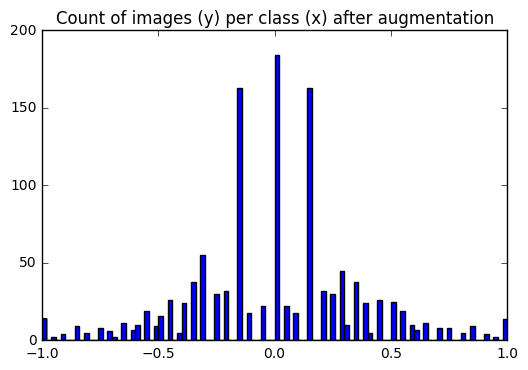

0.15
-0.15
Train on 1003 samples, validate on 251 samples
Epoch 1/1000
1003/1003 [==============================] - 0s - loss: 0.0892 - val_loss: 0.0924
Epoch 2/1000
1003/1003 [==============================] - 0s - loss: 0.0883 - val_loss: 0.0873
Epoch 3/1000
1003/1003 [==============================] - 0s - loss: 0.0838 - val_loss: 0.0820
Epoch 4/1000
1003/1003 [==============================] - 0s - loss: 0.0807 - val_loss: 0.0761
Epoch 5/1000
1003/1003 [==============================] - 0s - loss: 0.0775 - val_loss: 0.0697
Epoch 6/1000
1003/1003 [==============================] - 0s - loss: 0.0707 - val_loss: 0.0644
Epoch 7/1000
1003/1003 [==============================] - 0s - loss: 0.0700 - val_loss: 0.0604
Epoch 8/1000
1003/1003 [==============================] - 0s - loss: 0.0709 - val_loss: 0.0579
Epoch 9/1000
1003/1003 [==============================] - 0s - loss: 0.0694 - val_loss: 0.0564
Epoch 10/1000
1003/1003 [==============================] - 0s - loss: 0.0669 - val_loss

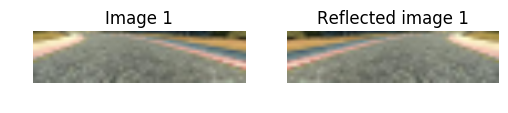

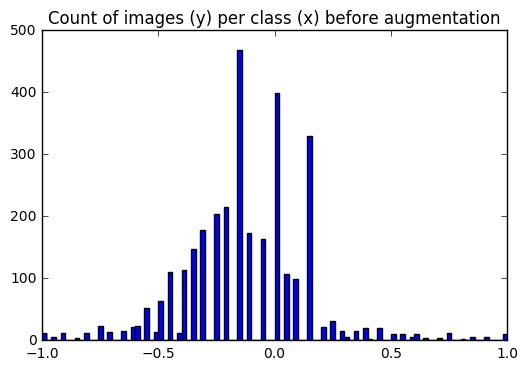

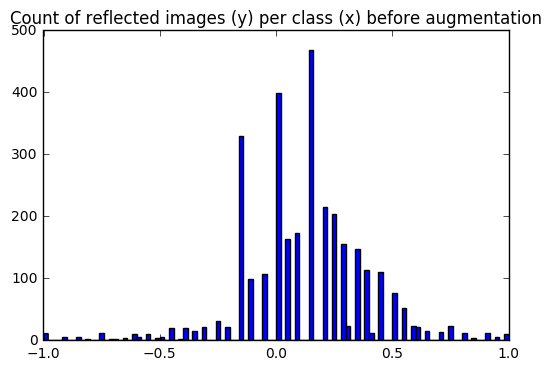

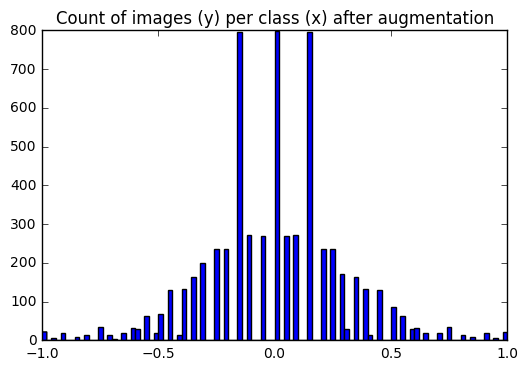

0.1
-0.1
Train on 5131 samples, validate on 1283 samples
Epoch 1/1000
5131/5131 [==============================] - 0s - loss: 0.0498 - val_loss: 0.0543
Epoch 2/1000
5131/5131 [==============================] - 0s - loss: 0.0449 - val_loss: 0.0405
Epoch 3/1000
5131/5131 [==============================] - 0s - loss: 0.0421 - val_loss: 0.0360
Epoch 4/1000
5131/5131 [==============================] - 0s - loss: 0.0405 - val_loss: 0.0380
Epoch 5/1000
5131/5131 [==============================] - 0s - loss: 0.0405 - val_loss: 0.0365
Epoch 6/1000
5131/5131 [==============================] - 0s - loss: 0.0396 - val_loss: 0.0359
Epoch 7/1000
5131/5131 [==============================] - 0s - loss: 0.0395 - val_loss: 0.0345
Epoch 8/1000
5131/5131 [==============================] - 0s - loss: 0.0388 - val_loss: 0.0344
Epoch 9/1000
5131/5131 [==============================] - 0s - loss: 0.0394 - val_loss: 0.0342
Epoch 10/1000
5131/5131 [==============================] - 0s - loss: 0.0385 - val_loss:

In [9]:
# train the model

all_data_sources = ["./data/", "./data-david-track1-1/", "./data-david-track1-2/"]

for source in all_data_sources:
    print("Training data from", source)
    X_train, y_train = load_data(source)
    X_train, y_train = shuffle(X_train, y_train)
    n_train = len(X_train)
    X_train, y_train = balance(X_train, y_train)
    X_normalized = normalize_minmax(X_train)
    history = model.fit(X_normalized, y_train, batch_size=512, nb_epoch=1000, validation_split=0.2)

print("Done training")

In [10]:
# save model to disk
model_filepath = "./model.h5"
if os.path.exists(model_filepath):
    os.remove(model_filepath)
model.save(model_filepath)
del model

** Let's run some validations on the model **


In [11]:
from keras.models import load_model

test_model = load_model(model_filepath)

source = "./data/"
X_test, y_test = load_data(source)
X_test, y_test = shuffle(X_test, y_test)
X_test = normalize_minmax(X_test)

Loading data from pickle file...


In [20]:
n_test = len(X_test)
index = random.randint(0, n_test)
test_image = X_test[index]
test_result = y_test[index]

result = float(test_model.predict(test_image[None, :, :, :], batch_size=1))

print("Expected", test_result, "obtained", result)

Expected -0.24015 obtained -0.2092319130897522
